In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import yt
import unyt
import tqdm
import pandas as pd
import trident as tr
from trident.absorption_spectrum.absorption_line import tau_profile
from linetools.lists.linelist import LineList

In [2]:
from linetools.analysis import absline
import astropy.units as u

In [3]:
import verdict

# Parameters

In [4]:
image_data_fp = './images.h5'

# Plotting choices
n_col=2
scalebar_size = 1
plot_all = False
selected = [ 'm12z_md:ys-16to-6_zs-15to-5', 'm12z_md:ys-20to-10_zs20to30', 'm12i_md:ys-20to-4_zs5to13', ]
mosaic = [
    [ 'm12z_md:ys-16to-6_zs-15to-5', 'm12z_md:ys-20to-10_zs20to30', ],
    [ 'm12i_md:ys-20to-4_zs5to13', 'm12i_md:ys-20to-4_zs5to13', ],
]

# Obs choices
EW_min = 0.01
EW_max = 1.0
b_default = 30. # In km/s
angular_resolution = 1 # In units of arcmin

In [5]:
# Presentation
figure_width = 3.376 # Default figure width in inches; MNRAS column width
max_figure_height = 9.437 # Text height for MNRAS
large_fontsize = 14.4
normal_fontsize = 12
small_fontsize = 10.95

cmap = 'cubehelix'

# Load Data

In [6]:
d = verdict.Dict.from_hdf5( image_data_fp )

/Users/zhafen/repos/verdict/verdict.py:1413: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


# Plot

## Setup

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

In [8]:
norm = matplotlib.colors.LogNorm( vmin=EW_min, vmax=EW_max )

In [9]:
fontproperties = fm.FontProperties( size=normal_fontsize, weight='bold' )

## Generate Plot

In [10]:
## Set up mosaic
image_keys = []
image_keys_row = []
for sim_key, sim_images in d.items():
    for image_key, image_values in sim_images.items():
        image_keys_row.append( sim_key + ':' + image_key )
        if len( image_keys_row ) >= n_col:
            image_keys.append( image_keys_row )
            image_keys_row = []

In [11]:
# Pad out remaining mosaic
if len( image_keys_row ) > 0:
    fill_list = [ 'empty', ] * ( n_col - len( image_keys_row ) )
    image_keys_row += fill_list
    image_keys.append( image_keys_row )

In [12]:
if plot_all:
    selected = np.hstack( image_keys )
    mosaic = image_keys

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_5093/2610975993.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  cax.set_yticklabels( [ '', 0.01, 0.1, 1 ] )
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_5093/2610975993.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=5)


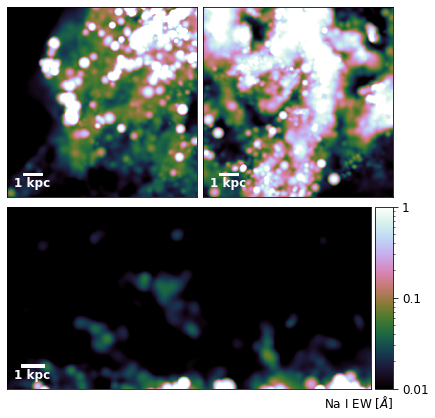

In [41]:
# Projected
n_row = len( mosaic )
fig = plt.figure(figsize=(figure_width*n_col,figure_width*n_row), facecolor='w')
main_ax = plt.gca()
main_ax.set_axis_off()
axs = fig.subplot_mosaic(
    mosaic = mosaic,
    gridspec_kw = { 'wspace': 0.03, 'hspace': 0.03 },
)

for img_key in selected:
    ax = axs[img_key]
    
    if img_key == 'empty':
        continue
        
    sim_key, image_key = img_key.split( ':' )
    image_values = d[sim_key][image_key]['zoom']
        
    # Full image
    image = ax.pcolormesh(
        image_values['ys'],
        image_values['zs'],
        np.rot90( image_values['img_arr'], k=-1 ),
        norm = norm,
        cmap = cmap,
    )
    
for ax_key, ax in axs.items():
    
    # Tick marks
    ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    
    # Aspect ratio
    ax.set_aspect( 'equal' )
    
    # Scalebar
    scalebar = AnchoredSizeBar(
        ax.transData,
        scalebar_size,
        '{} kpc'.format( scalebar_size ),
        loc = 'lower left',
        pad=0.5,
        color='w',
        frameon=False,
        size_vertical = scalebar_size / 10,
        fontproperties = fontproperties,
    )
    
    ax.add_artist( scalebar )
    
# Add colorbar
divider = make_axes_locatable( axs[mosaic[-1][-1]] )
cax = divider.append_axes("right", size="5%", pad='1%')
plt.colorbar( image, cax=cax )

cax.set_yticklabels( [ '', 0.01, 0.1, 1 ] ) 
cax.tick_params( labelsize=normal_fontsize, size=5 )

# Add annotation
cax.annotate(
    text = 'Na I EW [$\AA$]',
    xy = ( 1, 0 ),
    xycoords = 'axes fraction',
    xytext = ( 0, -5 ),
    textcoords = 'offset points',
    ha = 'right',
    va = 'top',
    fontsize = normal_fontsize,
)

In [42]:
save_fp = './visuals_pngs/multipanel.png'
fig.savefig( save_fp, dpi=300, bbox_inches='tight' )